___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Авторские права принадлежат Pierian Data Inc.</em></center>
<center><em>Для дополнительной информации посетите наш сайт <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# Регуляризация.

Регуляризация помогает решить несколько общих проблем моделей, применяя: 
* Минимизацию сложности модели 
* Штрафы на функцию потерь 
* Уменьшая переобученность модели (добаляя больше смещения, чтобы уменьшить дисперсию)

В двух словах регуляризация - это уменьшение переобученности модели (overfitting):
* Требует добавления смещения (bias)
* Требует поиска оптимального значения гиперпараметра для штрафа

# Регуляризация в SciKit-Learn

Ранее мы создали набор полиномиальных признаков и затем применили для них линейную регрессию. Но мы можем сделать модель ещё лучше, используя регуляризацию.

Регуляризация старается минимизировать метрику "сумма квадратов остатков" (RSS - residual sum of squares) *и* "функцию штрафа". Функция штрафа старается "наказывать" модели с очень большими коэффициентами. Некоторые методы регуляризации по сути приводят к тому, что некоторые неполезные признаки получают нулевые коэффициенты, то есть модель не будет использовать эти признаки.

Давайте рассмотрим два метода регуляризации - гребневая регрессия (или ридж-регрессия, или регрессия риджа, англ. ridge regression) и регрессия лассо. Мы будем использовать их в сочетании с полиномиальными признаками, поскольку регуляризация модели не так эффективна на исходном наборе признаков набора данных X.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных и подготовительные шаги

In [2]:
df = pd.read_csv("Advertising.csv")
X = df.drop('sales',axis=1)
y = df['sales']
df

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


### Полиномиальная конвертация

In [4]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_converter = PolynomialFeatures(degree=3, include_bias=False)
poly_features = polynomial_converter.fit_transform(X)
poly_features.shape

(200, 19)

### Разбиение на обучающий и тестовый наборы данных -  Train | Test Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)
X_train.shape

(140, 19)

----
----

## Масштабирование данных

Хотя в наших данных все признаки имеют один и тот же порядок величины (в $1000 долларов), это не всегда верно в других наборах данных. Поскольку математика регуляризации будет суммировать коэффициенты, очень важно стандартизировать признаки. Посмотрите теоретические видео-лекции для более подробного рассказа на эту тему, а также почему мы делаем **обучение (fit)** только на обучающих данных, и делаем **трансформацию** обоих наборов данных отдельно друг от друга.

* Метод .fit() вычисляет нужные метрики - X.min, X.max и тд. Т.е. делает подготовительную работу. 
* Метод .transform() - маштабирует данные и возвращает новую версию данных. 


Стандартизация: 

$X_{changed} = \frac{X_i - X.mean}{std}$


Нормализация: [0:1]

$X_{changed} = \frac{X - X_{min}}{X_{max} - X_{min}}$

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[0]

array([ 0.49300171, -0.33994238,  1.61586707,  0.28407363, -0.02568776,
        1.49677566, -0.59023161,  0.41659155,  1.6137853 ,  0.08057172,
       -0.05392229,  1.01524393, -0.36986163,  0.52457967,  1.48737034,
       -0.66096022, -0.16360242,  0.54694754,  1.37075536])

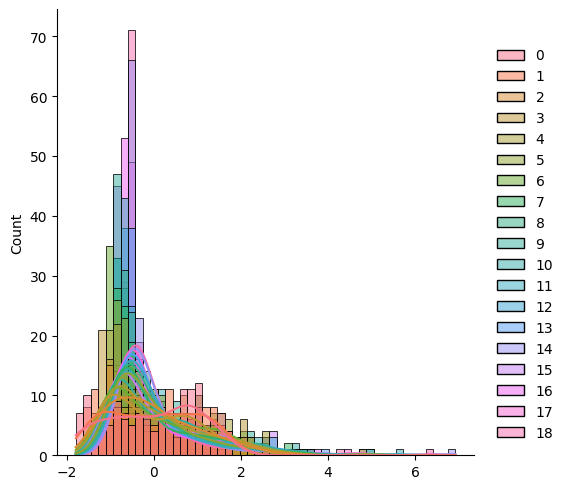

In [14]:
sns.displot(X_train_scaled, kde=True);

---
---
## Кросс-валидация (перекрёстная проверка)
* Это набор более продвинутых методов для разбиения данных на обучающий и тестовый наборы.
* Когда мы делаем простое разиение, то теряем возможность отлаживать гиперпараметры модели на всём объеме данных. 

* Т.е. блягодаря кросс-валидации, **можно обучать модель на всех данных + проверять модель на всех данных.**

1. Разбиваем train set на **K** равных частей. 
2. Если **K=10**, то отводим 1/10 часть данных на val. set. 
3. Вычисляем RSS для данного разбиения. 
4. Повторяем тот же процесс, но след. порцией данных с другим val. set. Получим 2-ой RSS. 
5. Повторяем **K** раз. 
6. После **K** итерации, усредняем **RSS** по всем итерациям. 

Небольшой минус: увеличение времени обучения в **K** раз.


---
---
## Гребневая регрессия (Ridge Regression)

Посмотрите видео-лекции по этой теме - там мы рассказываем про гребневую регрессию и про выбор параметра alpha.

* Это метод регуляризации, позволяющий снизить вероятность переобученности модели на обучающем наборе данных. 
* Достигается добалением штрафующего слагаемого к ошибке, с квадратом значений коэффициентов.

Вспомним формулу лин. рег.: 

$\^{y} = \^\beta_0 + \^\beta_1*x_1 + \^\beta_2*x_2 + ... + \^\beta_p*x_p $

**Находим коэффициенты бетта, минимизируя сумму квадратов остатков (residual sum of squares)**

$ RSS = \sum_{i=1}^{n}(y_j - \^{y}_j)^2 $

$ RSS = \sum_{i=1}^{n}(y_j - \^\beta_0 - \^\beta_1*x_1 - \^\beta_2*x_2 - ... - \^\beta_p*x_p)^2 $

$ RSS = \sum_{i=1}^{n}(y_j - \beta_0 - \sum_{i=1}^{n}\beta_j*x_{ij})^2 $

**Ridge:**

$ Error = \sum_{i=1}^{n}(y_j - \beta_0 - \sum_{i=1}^{n}\beta_j*x_{ij})^2 + \lambda\sum_{j=1}^{p}\beta_j^2  = RSS + \lambda\sum_{j=1}^{p}\beta_j^2 $

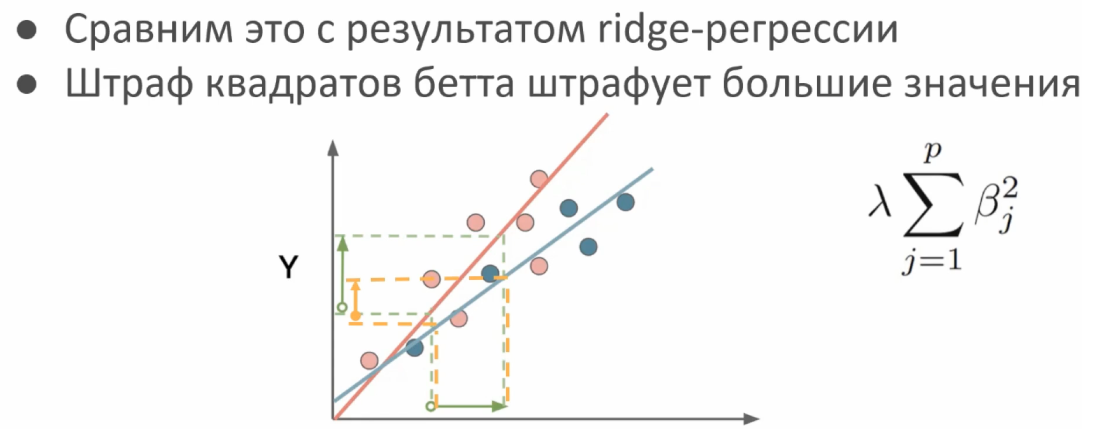 

Т.е. модель хорошо работает на train_set, но не test_set. 

В итоге, добавление слагаемого штрафа - штрафует слишком большой наклон линии. 

---
Параметр $\lambda$ - насколько сильно мы должны штрафовать?
1. Можно с помошью кросс-валидации попробовать разные значения альфа и выбрать оптимальный вариант

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_scaled, y_train)
y_pred = ridge_model.predict(X_test_scaled)

MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}')

MAE: 0.5774404204714175
MSE: 0.8003783071528375
RMSE: 0.8946386461319662


Какова точность на обучающей выборке? (Мы будем использовать это позже для сравнения)

In [26]:
# Производительность на обучающем наборе
train_predictions = ridge_model.predict(X_train)
MAE = mean_absolute_error(y_train,train_predictions)
MAE

0.5288348183025317

### Выбираем значение alpha с помощью кросс-валидации

Детали есть в видео-лекции.

In [ ]:
# Отрицательные значения RMSE. Все метрики следуют принципу "больше значит лучше".
# Чем больше значений alpha Вы укажете, тем дольше времени потребуется.
# К счастью наш набор данных достаточно маленький.

from sklearn.linear_model import RidgeCV

ridge_cv_model = RidgeCV(alphas=(0.1, 1.0, 10), scoring='neg_mean_absolute_error')
ridge_cv_model.fit(X_train_scaled, y_train)

ridge_cv_model.alpha_

np.float64(0.1)

In [20]:
y_pred = ridge_cv_model.predict(X_test_scaled)

MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}')

MAE: 0.4273774884345239
MSE: 0.3820129881545155
RMSE: 0.6180719926954428


In [21]:
ridge_cv_model.coef_

array([ 5.40769392,  0.5885865 ,  0.40390395, -6.18263924,  4.59607939,
       -1.18789654, -1.15200458,  0.57837796, -0.1261586 ,  2.5569777 ,
       -1.38900471,  0.86059434,  0.72219553, -0.26129256,  0.17870787,
        0.44353612, -0.21362436, -0.04622473, -0.06441449])

In [ ]:
from sklearn.metrics import get_scorer_names


-----
---

## Регрессия Lasso (Least absolute shrinkage and selection operator).

* L1 - регуляризация добавляет штраф пропорционально абсолютному значению коэффициентов. 

**Lasso:**

$ Error = \sum_{i=1}^{n}(y_j - \beta_0 - \sum_{i=1}^{n}\beta_j*x_{ij})^2 + \lambda\sum_{j=1}^{p}\left|\beta_j \right| = RSS + \lambda\sum_{j=1}^{p}\left|\beta_j \right|$

* Ограничивает размер коэффициентов.
* Может приводить к разреженным моделям, в которых некоторые коэффициенты становятся нулевыми. 
* **Lasso** может приравнивать некоторые коэффициенты в точности нулю, когда параметр альфа достаточно большой. 
* По сути, **Lasso** выбирает некоторые значимые признаки, а остальные отбрасываются. Модели, которые получаются в результате работы, обычно легче интерпретировать. 

In [24]:
from sklearn.linear_model import LassoCV

lasso_cv_model = LassoCV(eps=0.1, n_alphas=100, cv=5)
lasso_cv_model.fit(X_train_scaled, y_train)

LassoCV(cv=5, eps=0.1)

In [25]:
# оптимальное значение альфа (лямбда):
lasso_cv_model.alpha_

np.float64(0.4943070909225831)

In [26]:
y_pred = lasso_cv_model.predict(X_test_scaled)

MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}')

MAE: 0.6541723161252866
MSE: 1.2787088713079877
RMSE: 1.1308001022762546


In [27]:
lasso_cv_model.coef_

array([1.002651  , 0.        , 0.        , 0.        , 3.79745279,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

#### Можно улучшить результат увеличив max_iterations и уменьшив eps:

In [30]:
from sklearn.linear_model import LassoCV

lasso_cv_model = LassoCV(eps=0.001, n_alphas=100, cv=5, max_iter=1000000)
lasso_cv_model.fit(X_train_scaled, y_train)

print(f'Alpha score: {lasso_cv_model.alpha_}\n')

y_pred = lasso_cv_model.predict(X_test_scaled)

MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}\n')

print(f'Coef: {lasso_cv_model.coef_}')

Alpha score: 0.004943070909225831

MAE: 0.43350346185900673
MSE: 0.3676167574199057
RMSE: 0.6063140748984025

Coef: [ 4.86023329  0.12544598  0.20746872 -4.99250395  4.38026519 -0.22977201
 -0.          0.07267717 -0.          1.77780246 -0.69614918 -0.
  0.12044132 -0.         -0.         -0.          0.          0.
 -0.        ]


### Подытог:
#### Ridge (L2-регуляризация): штрафует за большие веса, ограничивает коэффициенты, но не зануляет их.
#### Lasso (L1-регуляризация): штрафует за большие веса, может занулять некоторые коэффициенты, исключая ненужные признаки из модели.
---

## Elastic Net

Elastic Net сочетает в себе ридж-регрессию и лассо-регрессию, чтобы взять лучшее из обеих регуляризаций!

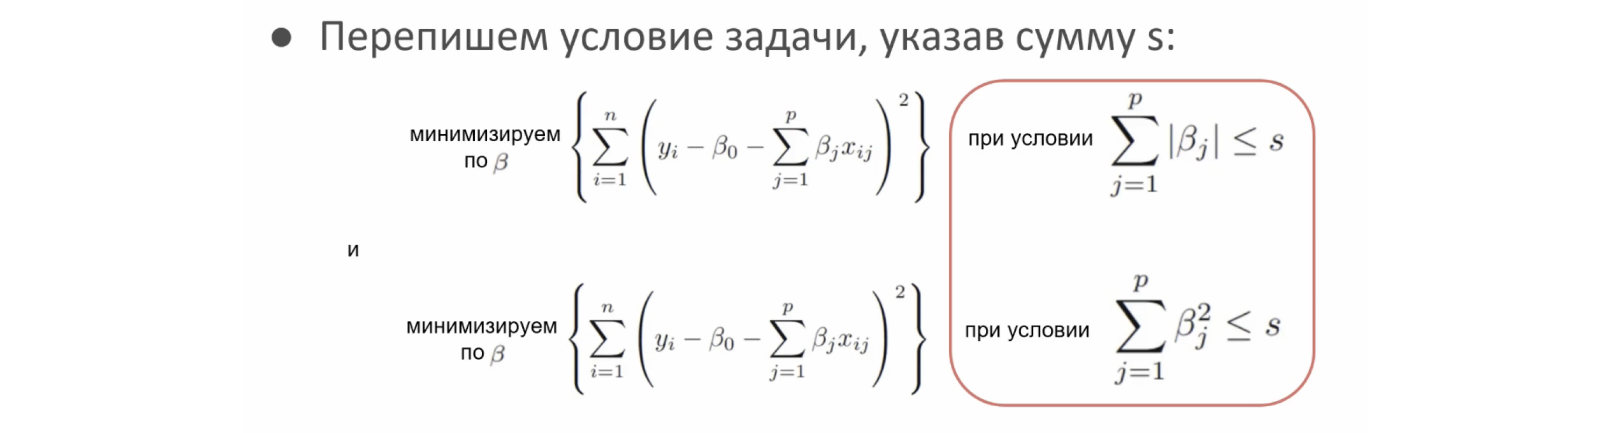

* По сути, отделили друг от друга, отдельно сумму квадратов ошибок и слагаемое штрафов.

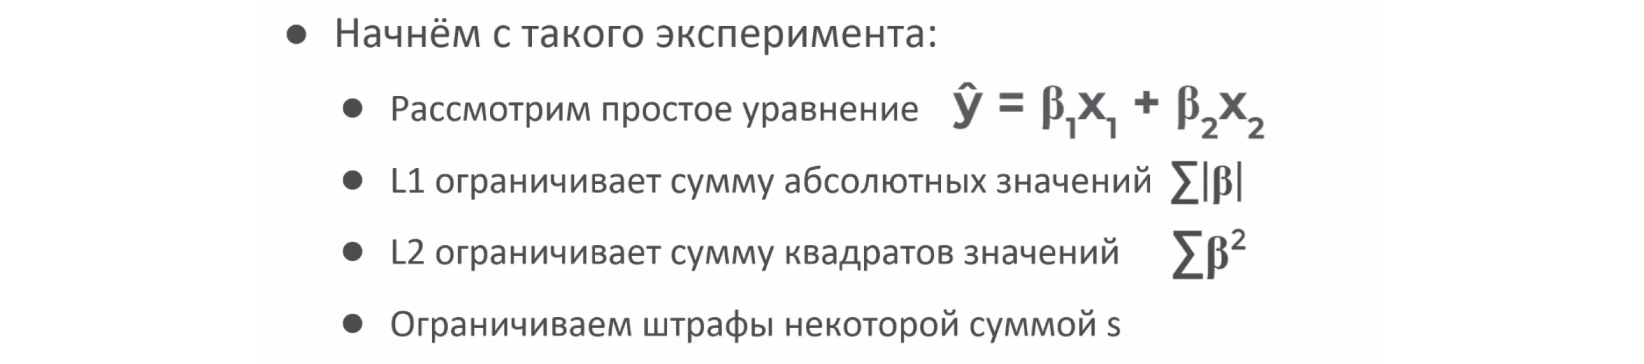

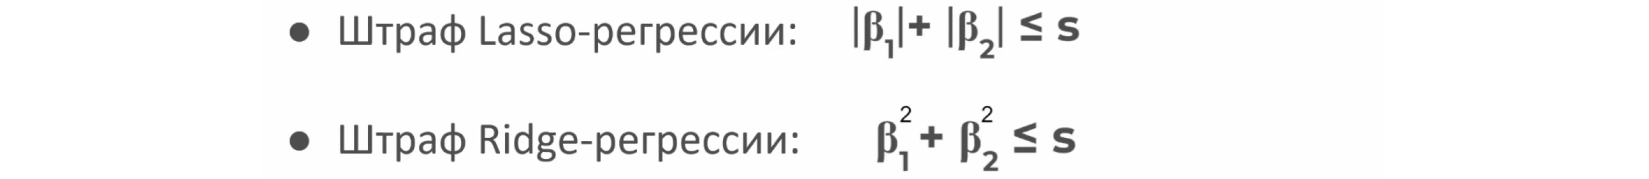

### Elastic net
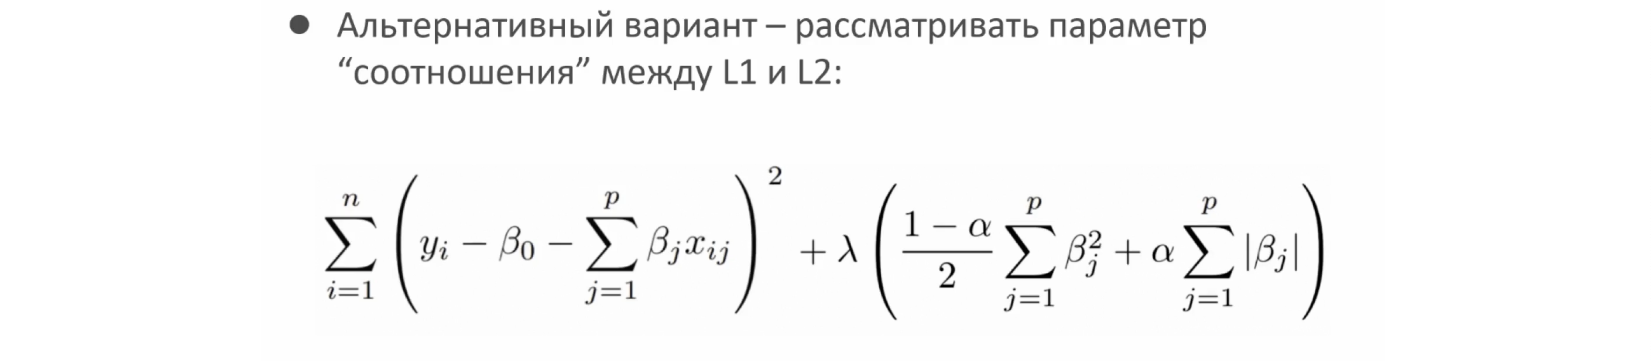

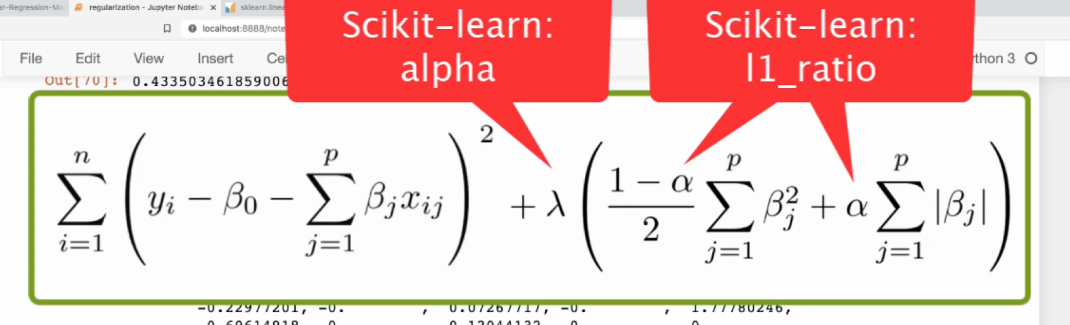

In [43]:
from sklearn.linear_model import ElasticNetCV

elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                             eps=0.001, n_alphas=100, max_iter=1000000)
elastic_model.fit(X_train_scaled,y_train)

print(f' L1_ratio: {elastic_model.l1_ratio_}')
print(f' Alpha: {elastic_model.alpha_:.5f}\n')

y_pred = elastic_model.predict(X_test_scaled)

MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

print(f'MAE: {MAE}')
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}\n')

print('Coefs:')
print(f'{elastic_model.coef_}')

 L1_ratio: 1.0
 Alpha: 0.00494

MAE: 0.43350346185900673
MSE: 0.3676167574199057
RMSE: 0.6063140748984025

Coefs:
[ 4.86023329  0.12544598  0.20746872 -4.99250395  4.38026519 -0.22977201
 -0.          0.07267717 -0.          1.77780246 -0.69614918 -0.
  0.12044132 -0.         -0.         -0.          0.          0.
 -0.        ]


-----
---

# Итоговый пайплайн: 
1. Делим на train/test set. 
2. Можно применить полиномиальную регрессию для признаков. 
3. Можно применить кросс-валидацию. 
4. Обучаем модель (fit/train). 
5. Оцениваем метрики. 
6. Настраиваем гиперпараметры модели. (Желательно применить кросс-валидацию заранее, чтобы модель не была знакома с test set, т.к. при к-в создается val. set). При настройке гиперпараметров, передаются крупицы информации, т.к. гиперпараметры настраиваются на основе всех данных.
7. Оцениваем. 
8. Внедряем модель. 